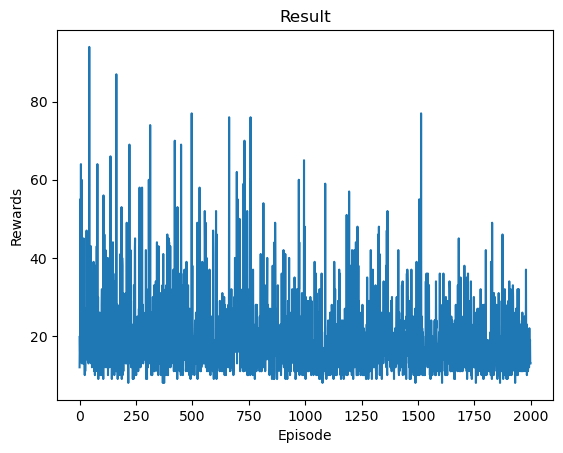

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [1]:
import gymnasium as gym
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from IPython import display
np.random.seed(2)
n_episode=2000
display_reward_threshold=475
max_ep_steps=500
RENDER=False
gamma=0.9
lr_a=0.0001
lr_c=0.001
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.ion()
#env=gym.make('CartPole-v1', render_mode='human')
env=gym.make('CartPole-v1')
env=env.unwrapped
 
N_F=env.observation_space.shape[0]
N_A=env.action_space.n
state=env.reset()
state=state[0]
state=torch.tensor(state,dtype=torch.float)
state=state[np.newaxis,:]
class actor_network(nn.Module):
    def __init__(self):
        super(actor_network,self).__init__()
        self.fc1=nn.Linear(N_F,64)
        self.fc2=nn.Linear(64,64)
        self.fc3=nn.Linear(64,N_A)
 
    def forward(self,x):#x:input state
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        fc3=self.fc3(x)
        acts_prob=F.softmax(fc3,dim=1)
        return acts_prob
 
    def initialize_weights(self):
        for m in self.modules():
            nn.init.normal_(m.weight.data,0,0.1)
            nn.init.constant_(m.bias.data,0.1)
 
class Actor(object):
    def __init__(self,n_features,n_actions,lr):
        self.features=n_features
        self.actions=n_actions
        self.lr_a=lr
        self.network=actor_network()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=self.lr_a)
 
    def choose_action(self,state):
        self.acts_prob=self.network.forward(state)
        #self.acts_probs.shape[1]是返回该tensor在维度1上的数据总数
        p=self.acts_prob.ravel()
        p=p.cpu().detach().numpy()
        return np.random.choice(np.arange(self.acts_prob.shape[1]),p=p)
 
    def learn(self,action,td):
        self.td_error=td
        log_prob=torch.log(self.acts_prob[0,action])
        loss=torch.mean(log_prob*self.td_error)#td_error是从critic中得到
        self.optimizer.zero_grad()#清空梯度
        loss.backward()
        self.optimizer.step()
        return loss
 
class critic_network(nn.Module):
    def __init__(self):
        super(critic_network,self).__init__()
        self.fc1=nn.Linear(N_F,32)
        self.fc2=nn.Linear(32,32)
        self.fc3=nn.Linear(32,1)
 
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        v_=self.fc3(x)
        return v_
 
    def initialize_weights(self):
        for m in self.modules():
            nn.init.normal_(m.weight.data, 0, 0.1)
            nn.init.constant_(m.bias.data, 0.1)
 
class Critic(object):
    def __init__(self,n_features,n_actions,lr=lr_c):
        self.features=n_features
        self.actions=n_actions
        self.lr_c=lr
        self.network=critic_network()
        self.optimizer=torch.optim.Adam(self.network.parameters(), lr=self.lr_c)
 
    def learn(self,state,reward,state_):
        self.v_=self.network.forward(state_)
        self.v=self.network.forward(state)
        self.td_error=reward+gamma*self.v_-self.v
        td_error=torch.square(self.td_error)
        self.optimizer.zero_grad()  # 清空梯度
        td_error.backward()
        self.optimizer.step()
 
        with torch.no_grad():
            td_error=reward+gamma*self.v_-self.v
 
        return td_error
 
episode_rewards=[]
def plot_rewards(show_result=False):
    plt.figure(1)
    #rewards_t=torch.tensor(episode_rewards, dtype=torch.float)
    if(show_result):
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...') 
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(episode_rewards)

    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())
 
actor=Actor(n_features=N_F,n_actions=N_A,lr=lr_a)
critic=Critic(n_features=N_F,n_actions=N_A,lr=lr_c)
for i_episode in range(n_episode):
    #re=0
    
    state=env.reset()
    state=state[0]
    state=torch.tensor(state,dtype=torch.float)
    state=state[np.newaxis,:]
    t=0
    track_r=[]
    while True:
        if RENDER:env.render()
        action=actor.choose_action(state)
        state_,reward,done,truncated,info=env.step(action)
        #re=re+reward
        state_ = torch.tensor(state_[np.newaxis], dtype=torch.float)
        if done:r=-20
        track_r.append(reward)
        td_error=critic.learn(state,reward,state_)
        actor.learn(action,td_error)
        state=state_
        t+=1
 
        if done or t>=max_ep_steps:
            ep_rs_sum=sum(track_r)
            if 'running_reward' not in globals():
                running_reward=ep_rs_sum
            else:
                running_reward=running_reward*0.95+ep_rs_sum*0.05
 
            if running_reward >display_reward_threshold:
                RENDER=True
            #print("episode:",i_episode,"reward: ",int(running_reward))
            break
    episode_rewards.append(sum(track_r))
    plot_rewards()
    env.render()
plot_rewards(show_result=True)
plt.ioff()
plt.show()
 